In [40]:
import os
os.environ["USE_PYGEOS"] = "0"

import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import folium
import seaborn as sns
import numpy as np

pd.options.display.max_rows = None  # Display all rows of a DataFrame
pd.options.display.max_columns = None  # Display all columns of a DataFrame
pd.options.mode.chained_assignment = None

import warnings

warnings.filterwarnings("ignore")

In [41]:
# Load your dataset (life expectancy by county)
data = pd.read_csv("data/chr_census_cleaned.csv", index_col=0, dtype={"geo_code": str, "year": int})

data["state_fips"] = data["geo_code"].apply(lambda x: str(x)[:2])

data['region'] = np.where(
    data['state_fips'].isin(["09", "23", "25", "33", "44", "50", "34", "36", "42"]), "Northeast", np.where(
        data['state_fips'].isin(["17", "18", "26", "39", "55", "19", "20", "27", "29", "31", "38", "46"]), "Midwest", np.where(
            data['state_fips'].isin(["10", "12", "13", "24", "37", "45", "51", "11", "54", "01", "21", "28", "47", "05", "22", "40", "48"]), "South", np.where(
                data['state_fips'].isin(["04", "08", "16", "30", "32", "35", "49", "56", "02", "06", "15", "41", "53"]), "West", np.nan
            )
        )
    )
)

data['division'] = np.where(
    data['state_fips'].isin(["09", "23", "25", "33", "44", "50"]), "New England", np.where(
        data['state_fips'].isin(["34", "36", "42"]), "Middle Atlantic", np.where(
            data['state_fips'].isin(["17", "18", "26", "39", "55"]), "East North Central", np.where(
                data['state_fips'].isin(["19", "20", "27", "29", "31", "38", "46"]), "West North Central", np.where(
                    data['state_fips'].isin(["10", "12", "13", "24", "37", "45", "51", "11", "54"]), "South Atlantic", np.where(
                        data['state_fips'].isin(["01", "21", "28", "47"]), "East South Central", np.where(
                            data['state_fips'].isin(["05", "22", "40", "48"]), "West South Central", np.where(
                                data['state_fips'].isin(["04", "08", "16", "30", "32", "35", "49", "56"]), "Mountain", np.where(
                                    data['state_fips'].isin(["02", "06", "15", "41", "53"]), "Pacific", np.nan
                                )
                            )
                        )
                    )
                )
            )
        )
    )
)

# Rank population within each region
data["pop_rank_by_year"] = data.groupby("year")["population"].rank(ascending=False)
data["median_hh_income_rank_by_year"] = data.groupby("year")[
    "median_household_income"
].rank(ascending=False)
data["rural_rank_by_year"] = data.groupby("year")["pct_rural"].rank(ascending=False)

data["pop_quantiles_by_year"] = data.groupby("year")["population"].transform(
    lambda x: pd.qcut(x, 5, labels=False)
)
data["pop_quantiles_by_year"] = data["pop_quantiles_by_year"].astype(str)

data["income_quantiles_by_year"] = data.groupby("year")[
    "median_household_income"
].transform(lambda x: pd.qcut(x, 5, labels=False))
data["income_quantiles_by_year"] = data["income_quantiles_by_year"].astype(str)


data.head()

,geo_code,year,geo_full_name,geo_name,state,state_code,adult_obesity,adult_smoking,air_pollution_particulate_matter,children_in_poverty,college_completion,dentists,diabetes_prevalence,drinking_water_violations,driving_alone_to_work,excessive_drinking,frequent_mental_distress,gender_pay_gap,homeownership,housing_units,hu_density,income_inequality,insufficient_sleep,latitude,life_expectancy,longitude,low_birthweight,mammography_screening,median_household_income,mental_health_providers,mobility_index_std,motor_vehicle_crash_deaths,pcp,pct_aian,pct_asian,pct_female,pct_finance_insurance_and_real_estate,pct_hispanic,pct_male_pop_45_64,pct_moved_from_abroad,pct_not_proficient_in_english,pct_professional_management_and_scientific_services,pct_rural,pop_density,population,premature_death,preventable_hospital_stays,severe_housing_problems,sexually_transmitted_infections,single_parent_households,social_associations,teen_births,unemployment_rate,uninsured_children,violent_crime,food_access_score,exercise_access_score,poor_health,state_fips,region,division,pop_rank_by_year,median_hh_income_rank_by_year,rural_rank_by_year,pop_quantiles_by_year,income_quantiles_by_year
0,01001,2010,"Autauga County, Alabama",Autauga,Alabama,AL,0.300,0.281400,12.9412,0.138000,0.217477,0.000259,0.11896,0.000000,0.868566,0.160546,0.128822,66.048439,0.775180,21530.0,36.219406,3.930128,0.367626,32.536382,75.607833,-86.644490,0.0883,0.668719,53255.0,0.000063,16.51,28.8,52.224775,0.004963,0.006547,0.515003,0.065322,0.023196,0.249884,0.002,0.009389,0.069964,0.422819,89.421390,53155.0,9778.1,91.803383,0.096612,370.0,0.179785,13.448252,47.513321,0.062076,0.028895,256.487012,2.499423,0.477935,3.292867,01,South,East South Central,925.0,516.0,2129.0,3,4
1,01003,2010,"Baldwin County, Alabama",Baldwin,Alabama,AL,0.245,0.230900,11.8769,0.193264,0.268221,0.000478,0.11214,0.096951,0.835134,0.177384,0.133441,68.766137,0.767301,101093.0,63.589498,4.214440,0.334602,30.659218,77.707111,-87.746067,0.0877,0.664884,50147.0,0.000788,21.87,23.6,70.741370,0.007428,0.006536,0.511340,0.068492,0.038955,0.273230,0.004,0.022074,0.098688,0.423983,110.576018,175791.0,8221.7,65.391299,0.116501,245.9,0.138206,11.396557,31.854171,0.065605,0.045870,171.623233,2.675232,0.485230,2.587933,01,South,East South Central,343.0,709.0,2123.0,4,3
2,01005,2010,"Barbour County, Alabama",Barbour,Alabama,AL,0.364,0.226800,12.3622,0.341000,0.135124,0.000361,0.14666,0.246521,0.789877,0.127674,0.151423,74.681632,0.680449,12011.0,13.573725,5.835112,0.394364,31.870670,75.719796,-85.405456,0.1100,0.635756,33219.0,0.000050,20.08,30.4,40.744262,0.005806,0.001661,0.471028,0.037945,0.045958,0.261057,0.000,0.021339,0.039156,0.678638,31.302857,27699.0,10686.1,92.297198,0.158040,585.7,0.225625,8.381110,87.486157,0.095894,0.051303,64.005310,1.885737,0.367540,3.398067,01,South,East South Central,1503.0,2742.0,1287.0,2,0
3,01007,2010,"Bibb County, Alabama",Bibb,Alabama,AL,0.317,0.249137,12.7501,0.242000,0.100252,0.000179,0.12166,0.000000,0.849911,0.122094,0.139013,69.830180,0.829190,8885.0,14.271285,4.332317,0.395793,33.015893,73.576596,-87.127148,0.0911,0.610994,41770.0,0.000073,10.39,41.3,42.105263,0.003612,0.001592,0.462096,0.057236,0.005927,0.259086,0.002,0.008245,0.046746,0.697744,36.316686,22610.0,13069.5,96.794256,0.066255,284.0,0.187878,10.242723,30.716724,0.091338,0.034706,127.580788,2.620188,0.340095,3.237233,01,South,East South Central,1697.0,1678.5,1232.0,2,2
4,01009,2010,"Blount County, Alabama",Blount,Alabama,AL,0.315,0.234200,12.3118,0.185000,0.125272,0.000190,0.12005,0.005384,0.806364,0.088601,0.150667,73.733161,0.820044,23482.0,36.419060,4.310364,0.367124,33.977448,75.623747,-86.567246,0.0726,0.607473,45549.0,0.000046,14.31,28.6,19.987281,0.006218,0.004339,0.504692,0.046264,0.074896,0.259615,0.006,0.042746,0.066947,0.899569,87.925617,56692.0,8929.7,102.021063,0.068867,85.1,0.142587,8.432691,36.640361,0.075270,0.046817,93.782854,2.817210,0.274598,3.446433,01,South,East South Central,884.0,1143.0,770.0,3,3


In [42]:
data.year.value_counts()

year
2010    3142
2011    3142
2012    3142
2013    3142
2014    3142
2015    3142
2016    3142
2017    3142
2018    3142
2019    3142
2020    3142
2021    3142
2022    3142
2023    3142
2024    3142
Name: count, dtype: int64

## Urbanization level

**Metropolitan counties:**
1. **Large central metro**
   - Counties in MSAs of 1 million or more population that: 
      1. Contain the entire population of the largest principal city of the MSA, or 
      2. Have their entire population contained in the largest principal city of the MSA, or 
      3. Contain at least 250,000 inhabitants of any principal city of the MSA
2. **Large fringe metro:**
   - Counties in MSAs of 1 million or more population that did not qualify as large central metro counties
3. **Medium metro:**
   - Counties in MSAs of populations of 250,000–999,999
4. **Small metro:**
   - Counties in MSAs of populations less than 250,000

**Nonmetropolitan counties:**

5. **Micropolitan:**
    - Counties in micropolitan statistical areas
6. **Non-core:**
    - counties that did not qualify as Core-Based Statistical Areas, i.e. metropolitan or metropolitan statistical areas 
 

In [43]:
df_list = []
year_list = ["2013", "2015", "2017", "2018", "2019", "2020", "2023"]

cbsa_msa_2009 = pd.read_excel(
    "data/Urban Rural/cbsa_msa_county_2003_2023.xlsx",
    sheet_name="2009",
    dtype={"cbsa_code": str, "geo_code": str},
)
cbsa_msa_2009["year"] = 2010

df_list.append(cbsa_msa_2009)

cbsa_msa_2009.head()

,CBSA Title,cbsa_code,county_name,state_name,geo_code,county_status,cbsa_level,csa_status,cbsa_status,year
0,"Montgomery, AL",33860,Autauga County,Alabama,01001,Outlying,Metro,CSA,CBSA,2010
1,"Daphne-Fairhope-Foley, AL",19300,Baldwin County,Alabama,01003,Central,Micro,CSA,CBSA,2010
2,"Eufaula, AL-GA",21640,Barbour County,Alabama,01005,Central,Micro,non-CSA,CBSA,2010
3,"Birmingham-Hoover, AL",13820,Bibb County,Alabama,01007,Outlying,Metro,CSA,CBSA,2010
4,"Birmingham-Hoover, AL",13820,Blount County,Alabama,01009,Outlying,Metro,CSA,CBSA,2010


In [44]:
for year in year_list:
    cbsa_msa = pd.read_excel("data/Urban Rural/cbsa_msa_county_2003_2023.xlsx", sheet_name=year, dtype={"cbsa_code": str, "state_fips": str, "county_fips": str})
    cbsa_msa["geo_code"] = cbsa_msa["state_fips"] + cbsa_msa["county_fips"]
    cbsa_msa.drop(columns=['state_fips', 'county_fips'], inplace=True)
    cbsa_msa['year'] = int(year)
    df_list.append(cbsa_msa)

In [45]:
cbsa_msa = pd.concat(df_list, axis=0)
cbsa_msa.head()

,CBSA Title,cbsa_code,county_name,state_name,geo_code,county_status,cbsa_level,csa_status,cbsa_status,year
0,"Montgomery, AL",33860,Autauga County,Alabama,01001,Outlying,Metro,CSA,CBSA,2010
1,"Daphne-Fairhope-Foley, AL",19300,Baldwin County,Alabama,01003,Central,Micro,CSA,CBSA,2010
2,"Eufaula, AL-GA",21640,Barbour County,Alabama,01005,Central,Micro,non-CSA,CBSA,2010
3,"Birmingham-Hoover, AL",13820,Bibb County,Alabama,01007,Outlying,Metro,CSA,CBSA,2010
4,"Birmingham-Hoover, AL",13820,Blount County,Alabama,01009,Outlying,Metro,CSA,CBSA,2010


In [46]:
cbsa_msa.year.value_counts()

year
2023    1844
2020    1841
2019    1840
2018    1826
2015    1825
2017    1825
2013    1808
2010    1788
Name: count, dtype: int64

In [47]:
pop_2020 = pd.read_csv(
    "data/Urban Rural/population_files/ACSDP5Y2020.DP05-Data.csv",
    header=1,
)
pop_2020 = pop_2020.iloc[:, :3]
pop_2020.columns = ['cbsa_code', 'cbsa_title', 'population']
pop_2020['cbsa_title'] = pop_2020['cbsa_title'].apply(lambda x: str(x)[:-10])
pop_2020['cbsa_code'] = pop_2020['cbsa_code'].apply(lambda x: str(x)[-5:])
pop_2020['year'] = 2020
pop_2020.head()

,cbsa_code,cbsa_title,population,year
0,000US,Uni,326569308,2020
1,10100,"Aberdeen, SD",42864,2020
2,10140,"Aberdeen, WA",73769,2020
3,10180,"Abilene, TX",171354,2020
4,10220,"Ada, OK",38385,2020


In [48]:
year_list = ['2010', '2013', '2015', '2017', '2018', '2019', '2020', '2023']

df_list = []

for year in year_list:
    if year == '2023':
        pop = pd.read_csv(
            f"data/Urban Rural/population_files/ACSDP1Y{year}.DP05-Data.csv",
            header=1,
        )
    else:
        pop = pd.read_csv(
            f"data/Urban Rural/population_files/ACSDP5Y{year}.DP05-Data.csv",
            header=1,
        )
    pop = pop.iloc[:, :3]
    pop.columns = ["cbsa_code", "cbsa_title", "population"]
    pop["year"] = int(year)
    pop["cbsa_code"] = pop["cbsa_code"].apply(lambda x: str(x)[-5:])
    pop = pop.pivot_table(index=['cbsa_code'], columns='year', values='population', aggfunc='sum')
    df_list.append(pop)

In [49]:
pop_df = df_list[0].join(df_list[1], how='outer').join(df_list[2], how='outer').join(df_list[3], how='outer').join(df_list[4], how='outer').join(df_list[5], how='outer').join(df_list[6], how='outer').join(df_list[7], how='outer')
pop_df.head()

year,2010,2013,2015,2017,2018,2019,2020,2023
cbsa_code,,,,,,,,
000US,303965272.0,311536594.0,316515021.0,321004407.0,322903030.0,324697795.0,326569308.0,NaN
10020,57280.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10100,40058.0,41033.0,42078.0,42608.0,42780.0,42824.0,42864.0,NaN
10140,72092.0,72092.0,71419.0,71454.0,71967.0,72779.0,73769.0,77290.0
10180,163092.0,166202.0,167945.0,169000.0,170009.0,170669.0,171354.0,180224.0


In [50]:
pop_pivot = pop_df.stack().reset_index()
pop_pivot.columns = ['cbsa_code', 'year', 'cbsa_population']
pop_pivot.head()

,cbsa_code,year,cbsa_population
0,000US,2010,303965272.0
1,000US,2013,311536594.0
2,000US,2015,316515021.0
3,000US,2017,321004407.0
4,000US,2018,322903030.0


In [51]:
merged = cbsa_msa.merge(pop_pivot, on=['cbsa_code', 'year'], how='left')
merged.head()

,CBSA Title,cbsa_code,county_name,state_name,geo_code,county_status,cbsa_level,csa_status,cbsa_status,year,cbsa_population
0,"Montgomery, AL",33860,Autauga County,Alabama,01001,Outlying,Metro,CSA,CBSA,2010,370554.0
1,"Daphne-Fairhope-Foley, AL",19300,Baldwin County,Alabama,01003,Central,Micro,CSA,CBSA,2010,175791.0
2,"Eufaula, AL-GA",21640,Barbour County,Alabama,01005,Central,Micro,non-CSA,CBSA,2010,30227.0
3,"Birmingham-Hoover, AL",13820,Bibb County,Alabama,01007,Outlying,Metro,CSA,CBSA,2010,1115485.0
4,"Birmingham-Hoover, AL",13820,Blount County,Alabama,01009,Outlying,Metro,CSA,CBSA,2010,1115485.0


In [52]:
data_head = data[['geo_code', 'year']]
data_head = data_head.loc[data_head['year'].isin([2010, 2013, 2015, 2017, 2018, 2019, 2020, 2023])]
data_merge = data_head.merge(merged, on=['geo_code', 'year'], how='left')
data_merge.head()

,geo_code,year,CBSA Title,cbsa_code,county_name,state_name,county_status,cbsa_level,csa_status,cbsa_status,cbsa_population
0,01001,2010,"Montgomery, AL",33860,Autauga County,Alabama,Outlying,Metro,CSA,CBSA,370554.0
1,01003,2010,"Daphne-Fairhope-Foley, AL",19300,Baldwin County,Alabama,Central,Micro,CSA,CBSA,175791.0
2,01005,2010,"Eufaula, AL-GA",21640,Barbour County,Alabama,Central,Micro,non-CSA,CBSA,30227.0
3,01007,2010,"Birmingham-Hoover, AL",13820,Bibb County,Alabama,Outlying,Metro,CSA,CBSA,1115485.0
4,01009,2010,"Birmingham-Hoover, AL",13820,Blount County,Alabama,Outlying,Metro,CSA,CBSA,1115485.0


In [53]:
data_merge.loc[data_merge.cbsa_status.isnull(), 'cbsa_status'] = 'Non-CBSA'
data_merge.loc[data_merge.cbsa_level.isnull(), 'cbsa_level'] = 'Non-Core'

In [54]:
for index, row in data_merge.iterrows():
    if (row['cbsa_level'] == 'Metro') & (row['county_status'] == 'Central') & (row['cbsa_population'] >= 1000000):
        data_merge.loc[index, 'cbsa_status'] = 'Large Central Metro'
    elif (row['cbsa_level'] == 'Metro') & (row['county_status'] == 'Outlying') & (row['cbsa_population'] >= 1000000):
        data_merge.loc[index, 'cbsa_status'] = 'Large Outlying Metro'
    elif (row['cbsa_level'] == 'Metro') & (row['cbsa_population'] < 1000000) & (row['cbsa_population'] >= 250000):
        data_merge.loc[index, 'cbsa_status'] = 'Medium Metro'
    elif (row['cbsa_level'] == 'Metro') & (row['cbsa_population'] < 250000):
        data_merge.loc[index, 'cbsa_status'] = 'Small Metro'
    elif row['cbsa_level'] == 'Micro':
        data_merge.loc[index, 'cbsa_status'] = 'Micropolitan'
    elif row['cbsa_level'] == 'Non-Core':
        data_merge.loc[index, 'cbsa_status'] = 'Non-Core'
    else:
        data_merge.loc[index, 'cbsa_status'] = np.nan

In [55]:
data_merge.head()

,geo_code,year,CBSA Title,cbsa_code,county_name,state_name,county_status,cbsa_level,csa_status,cbsa_status,cbsa_population
0,01001,2010,"Montgomery, AL",33860,Autauga County,Alabama,Outlying,Metro,CSA,Medium Metro,370554.0
1,01003,2010,"Daphne-Fairhope-Foley, AL",19300,Baldwin County,Alabama,Central,Micro,CSA,Micropolitan,175791.0
2,01005,2010,"Eufaula, AL-GA",21640,Barbour County,Alabama,Central,Micro,non-CSA,Micropolitan,30227.0
3,01007,2010,"Birmingham-Hoover, AL",13820,Bibb County,Alabama,Outlying,Metro,CSA,Large Outlying Metro,1115485.0
4,01009,2010,"Birmingham-Hoover, AL",13820,Blount County,Alabama,Outlying,Metro,CSA,Large Outlying Metro,1115485.0


In [66]:
df = data.merge(data_merge[['geo_code', 'year', 'cbsa_status']], on=['geo_code', 'year'], how='left')
df.head()

,geo_code,year,geo_full_name,geo_name,state,state_code,adult_obesity,adult_smoking,air_pollution_particulate_matter,children_in_poverty,college_completion,dentists,diabetes_prevalence,drinking_water_violations,driving_alone_to_work,excessive_drinking,frequent_mental_distress,gender_pay_gap,homeownership,housing_units,hu_density,income_inequality,insufficient_sleep,latitude,life_expectancy,longitude,low_birthweight,mammography_screening,median_household_income,mental_health_providers,mobility_index_std,motor_vehicle_crash_deaths,pcp,pct_aian,pct_asian,pct_female,pct_finance_insurance_and_real_estate,pct_hispanic,pct_male_pop_45_64,pct_moved_from_abroad,pct_not_proficient_in_english,pct_professional_management_and_scientific_services,pct_rural,pop_density,population,premature_death,preventable_hospital_stays,severe_housing_problems,sexually_transmitted_infections,single_parent_households,social_associations,teen_births,unemployment_rate,uninsured_children,violent_crime,food_access_score,exercise_access_score,poor_health,state_fips,region,division,pop_rank_by_year,median_hh_income_rank_by_year,rural_rank_by_year,pop_quantiles_by_year,income_quantiles_by_year,cbsa_status
0,01001,2010,"Autauga County, Alabama",Autauga,Alabama,AL,0.300,0.281400,12.9412,0.138000,0.217477,0.000259,0.11896,0.000000,0.868566,0.160546,0.128822,66.048439,0.775180,21530.0,36.219406,3.930128,0.367626,32.536382,75.607833,-86.644490,0.0883,0.668719,53255.0,0.000063,16.51,28.8,52.224775,0.004963,0.006547,0.515003,0.065322,0.023196,0.249884,0.002,0.009389,0.069964,0.422819,89.421390,53155.0,9778.1,91.803383,0.096612,370.0,0.179785,13.448252,47.513321,0.062076,0.028895,256.487012,2.499423,0.477935,3.292867,01,South,East South Central,925.0,516.0,2129.0,3,4,Medium Metro
1,01003,2010,"Baldwin County, Alabama",Baldwin,Alabama,AL,0.245,0.230900,11.8769,0.193264,0.268221,0.000478,0.11214,0.096951,0.835134,0.177384,0.133441,68.766137,0.767301,101093.0,63.589498,4.214440,0.334602,30.659218,77.707111,-87.746067,0.0877,0.664884,50147.0,0.000788,21.87,23.6,70.741370,0.007428,0.006536,0.511340,0.068492,0.038955,0.273230,0.004,0.022074,0.098688,0.423983,110.576018,175791.0,8221.7,65.391299,0.116501,245.9,0.138206,11.396557,31.854171,0.065605,0.045870,171.623233,2.675232,0.485230,2.587933,01,South,East South Central,343.0,709.0,2123.0,4,3,Micropolitan
2,01005,2010,"Barbour County, Alabama",Barbour,Alabama,AL,0.364,0.226800,12.3622,0.341000,0.135124,0.000361,0.14666,0.246521,0.789877,0.127674,0.151423,74.681632,0.680449,12011.0,13.573725,5.835112,0.394364,31.870670,75.719796,-85.405456,0.1100,0.635756,33219.0,0.000050,20.08,30.4,40.744262,0.005806,0.001661,0.471028,0.037945,0.045958,0.261057,0.000,0.021339,0.039156,0.678638,31.302857,27699.0,10686.1,92.297198,0.158040,585.7,0.225625,8.381110,87.486157,0.095894,0.051303,64.005310,1.885737,0.367540,3.398067,01,South,East South Central,1503.0,2742.0,1287.0,2,0,Micropolitan
3,01007,2010,"Bibb County, Alabama",Bibb,Alabama,AL,0.317,0.249137,12.7501,0.242000,0.100252,0.000179,0.12166,0.000000,0.849911,0.122094,0.139013,69.830180,0.829190,8885.0,14.271285,4.332317,0.395793,33.015893,73.576596,-87.127148,0.0911,0.610994,41770.0,0.000073,10.39,41.3,42.105263,0.003612,0.001592,0.462096,0.057236,0.005927,0.259086,0.002,0.008245,0.046746,0.697744,36.316686,22610.0,13069.5,96.794256,0.066255,284.0,0.187878,10.242723,30.716724,0.091338,0.034706,127.580788,2.620188,0.340095,3.237233,01,South,East South Central,1697.0,1678.5,1232.0,2,2,Large Outlying Metro
4,01009,2010,"Blount County, Alabama",Blount,Alabama,AL,0.315,0.234200,12.3118,0.185000,0.125272,0.000190,0.12005,0.005384,0.806364,0.088601,0.150667,73.733161,0.820044,23482.0,36.419060,4.310364,0.367124,33.977448,75.623747,-86.567246,0.0726,0.607473,45549.0,0.000046,14.31,28.6,19.987281,0.006218,0.004339,0.504692,0.046264,0.074896,0.259615,0.006,0.042746,0.066947,0.899569,87.925617,56692.0,8929.7,102.021063,0.068867,85.1,0.142587,8.432691,36.640361,0.075270,0.046817,93.782854,2.817210,0.

In [70]:
df.groupby(by="year").cbsa_status.value_counts(dropna=False)

year  cbsa_status         
2010  Non-Core                1355
      Micropolitan             688
      Medium Metro             344
      Small Metro              335
      Large Central Metro      234
      Large Outlying Metro     186
2011  Non-Core                1355
      Micropolitan             688
      Medium Metro             344
      Small Metro              335
      Large Central Metro      234
      Large Outlying Metro     186
2012  Non-Core                1355
      Micropolitan             688
      Medium Metro             344
      Small Metro              335
      Large Central Metro      234
      Large Outlying Metro     186
2013  Non-Core                1335
      Micropolitan             641
      Medium Metro             378
      Small Metro              356
      Large Central Metro      255
      Large Outlying Metro     177
2014  Non-Core                1335
      Micropolitan             641
      Medium Metro             378
      Small Metro           

In [69]:
df.sort_values(by=['geo_code', 'year'], inplace=True)

df['cbsa_status'] = df.groupby('geo_code')['cbsa_status'].ffill()
df['cbsa_status'] = df.groupby('geo_code')['cbsa_status'].bfill()

In [71]:
df.to_csv('data/chr_census_dataset_eda.csv')

In [15]:
df = pd.read_csv('data/chr_census_dataset_eda.csv', index_col=0, dtype={"geo_code": str, "state_fips": str, "year": int})

In [21]:
columns = [
    "geo_code",
    "year",
    "geo_full_name",
    "geo_name",
    "state",
    "state_code",
    "state_fips",
    "region",
    "division",
    "latitude",
    "longitude",
    "pop_quantiles_by_year",
    "income_quantiles_by_year",
    "cbsa_status",
    "life_expectancy",
    "pop_density",
    "population",
    "adult_obesity",
    "adult_smoking",
    "excessive_drinking",
    "low_birthweight",
    "diabetes_prevalence",
    "sexually_transmitted_infections",
    "teen_births",
    "preventable_hospital_stays",
    "food_access_score",
    "exercise_access_score",
    "poor_health",
    "insufficient_sleep",
    "pcp",
    "dentists",
    "mental_health_providers",
    "uninsured_children",
    "social_associations",
    "premature_death",
    "driving_alone_to_work",
    "motor_vehicle_crash_deaths",
    "frequent_mental_distress",
    "gender_pay_gap",
    "air_pollution_particulate_matter",
    "children_in_poverty",
    "single_parent_households",
    "violent_crime",
    "college_completion",
    "homeownership",
    "severe_housing_problems",
    "unemployment_rate",
    "income_inequality",
    "mammography_screening",
    "median_household_income",
    "mobility_index_std",
    "pct_moved_from_abroad",
    "pct_not_proficient_in_english",
    "pct_rural",
    "pct_aian",
    "pct_asian",
    "pct_hispanic",
    "pct_male_pop_45_64",
    "pct_female",
    "pct_finance_insurance_and_real_estate",
    "pct_professional_management_and_scientific_services"
]

df = df[columns]

In [22]:
df.columns.tolist()

['geo_code',
 'year',
 'geo_full_name',
 'geo_name',
 'state',
 'state_code',
 'state_fips',
 'region',
 'division',
 'latitude',
 'longitude',
 'pop_quantiles_by_year',
 'income_quantiles_by_year',
 'cbsa_status',
 'life_expectancy',
 'pop_density',
 'population',
 'adult_obesity',
 'adult_smoking',
 'excessive_drinking',
 'low_birthweight',
 'diabetes_prevalence',
 'sexually_transmitted_infections',
 'teen_births',
 'preventable_hospital_stays',
 'food_access_score',
 'exercise_access_score',
 'poor_health',
 'insufficient_sleep',
 'pcp',
 'dentists',
 'mental_health_providers',
 'uninsured_children',
 'social_associations',
 'premature_death',
 'driving_alone_to_work',
 'motor_vehicle_crash_deaths',
 'frequent_mental_distress',
 'gender_pay_gap',
 'air_pollution_particulate_matter',
 'children_in_poverty',
 'single_parent_households',
 'violent_crime',
 'college_completion',
 'homeownership',
 'severe_housing_problems',
 'unemployment_rate',
 'income_inequality',
 'mammography_scree

# Top 10 Positive and Negative Correlations

In [23]:
feat_cont = df[[
    "life_expectancy",
    "pop_density",
    "population",
    "adult_obesity",
    "adult_smoking",
    "excessive_drinking",
    "low_birthweight",
    "diabetes_prevalence",
    "sexually_transmitted_infections",
    "teen_births",
    "preventable_hospital_stays",
    "food_access_score",
    "exercise_access_score",
    "poor_health",
    "insufficient_sleep",
    "pcp",
    "dentists",
    "mental_health_providers",
    "uninsured_children",
    "social_associations",
    "premature_death",
    "driving_alone_to_work",
    "motor_vehicle_crash_deaths",
    "frequent_mental_distress",
    "gender_pay_gap",
    "air_pollution_particulate_matter",
    "children_in_poverty",
    "single_parent_households",
    "violent_crime",
    "college_completion",
    "homeownership",
    "severe_housing_problems",
    "unemployment_rate",
    "income_inequality",
    "mammography_screening",
    "median_household_income",
    "mobility_index_std",
    "pct_moved_from_abroad",
    "pct_not_proficient_in_english",
    "pct_rural",
    "pct_aian",
    "pct_asian",
    "pct_hispanic",
    "pct_male_pop_45_64",
    "pct_female",
    "pct_finance_insurance_and_real_estate",
    "pct_professional_management_and_scientific_services",
]]

In [24]:
# Calculating the correlation matrix between life expectancy and all other numeric variables
correlation_matrix = feat_cont.corr()

# Selecting correlations with life expectancy and sorting them
life_expectancy_corr = correlation_matrix["life_expectancy"].sort_values(
    ascending=False
)

# Display the top correlations (both positive and negative) with life expectancy
top_positive_corr = life_expectancy_corr.head(15)
top_negative_corr = life_expectancy_corr.tail(15)

top_positive_corr, top_negative_corr

(life_expectancy                                        1.000000
 college_completion                                     0.573507
 median_household_income                                0.531112
 food_access_score                                      0.448437
 excessive_drinking                                     0.400704
 pct_asian                                              0.320067
 pct_finance_insurance_and_real_estate                  0.310775
 pct_professional_management_and_scientific_services    0.297328
 mammography_screening                                  0.279283
 dentists                                               0.222237
 pct_moved_from_abroad                                  0.220119
 pct_not_proficient_in_english                          0.205565
 exercise_access_score                                  0.190589
 population                                             0.179691
 mobility_index_std                                     0.172724
 Name: life_expectancy, d

In [25]:
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [32]:
numeric_data = df.select_dtypes(include=[np.number])
X = numeric_data.drop(
    columns=["life_expectancy", "year", "income_quantiles_by_year", "pop_quantiles_by_year", "pop_density"], axis=1
)  # Drop the target variable if it’s in the DataFrame
X = StandardScaler().fit_transform(X)  # Standardize features

vif_data = pd.DataFrame()
vif_data["feature"] = numeric_data.columns.drop(["life_expectancy", "year", "income_quantiles_by_year", "pop_quantiles_by_year", "pop_density"])
vif_data["VIF"] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]

# Display the VIF values
pd.DataFrame(vif_data).sort_values(by="VIF", ascending=False)

,feature,VIF
29,college_completion,5.197804
35,median_household_income,5.179349
23,frequent_mental_distress,4.696201
14,insufficient_sleep,3.943175
39,pct_rural,3.802611
42,pct_hispanic,3.684967
26,children_in_poverty,3.576591
20,premature_death,3.526208
13,poor_health,3.417589
31,severe_housing_problems,3.344568


In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("fivethirtyeight")

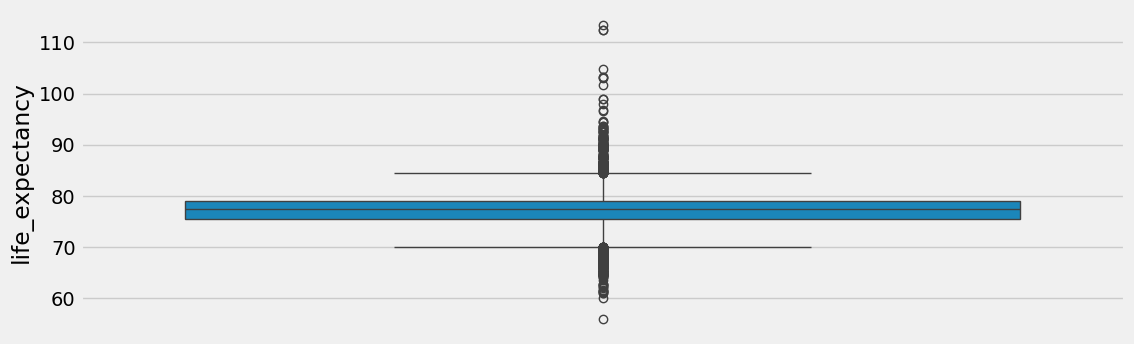

In [11]:
fig, ax = plt.subplots(figsize=(12, 4))
ax = sns.boxplot(df.life_expectancy)

# Distribution of Features

In [29]:
col_con = feat_cont.columns

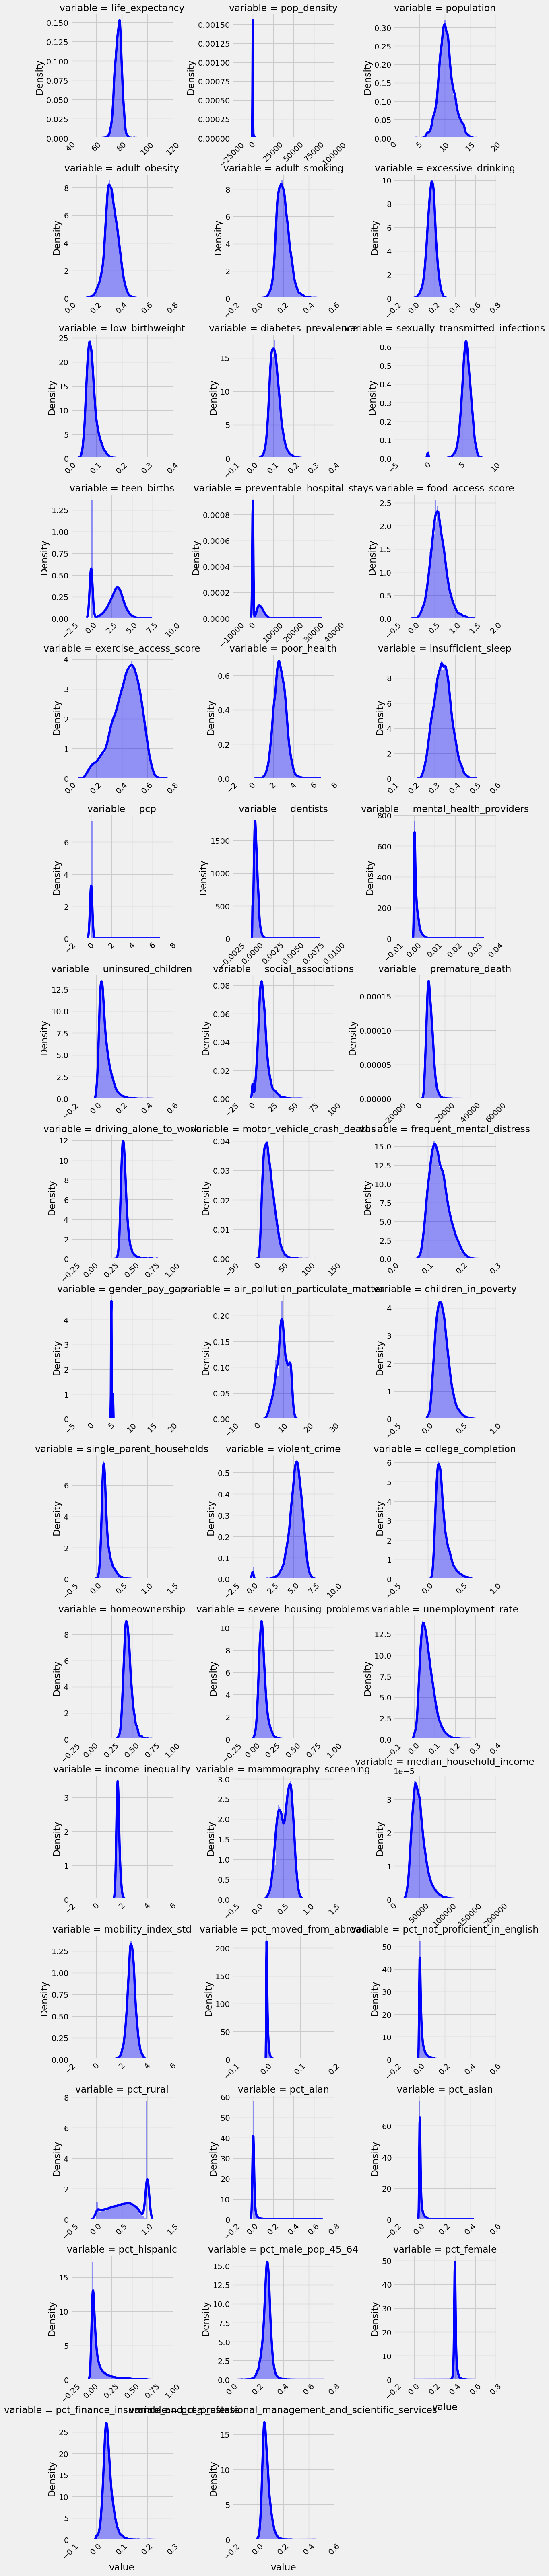

In [36]:
con_1 = pd.melt(df, value_vars=col_con)
g = sns.FacetGrid(
    con_1, col="variable", col_wrap=3, sharex=False, sharey=False, height=4
)
g = g.map(sns.distplot, "value", color="b")
g.set_xticklabels(rotation=45)

In [31]:
from scipy.stats import skew
import pandas as pd

# Select only numerical columns
numerical_columns = df.select_dtypes(include=["float64", "int64"]).columns

# Calculate skewness for each numerical column
skewness_values = df[numerical_columns].apply(lambda x: skew(x.dropna()))

# Create a DataFrame for better readability
skewness_summary = pd.DataFrame(skewness_values.sort_values(ascending=False).reset_index())
skewness_summary.columns = ["Feature", "Skewness"]
skewness_summary.sort_values(by="Skewness", ascending=False, inplace=True)

# Display skewness summary
skewness_summary

,Feature,Skewness
0,income_inequality,80.279553
1,pop_density,26.710422
2,population,13.783175
3,pct_moved_from_abroad,9.258852
4,pcp,8.090455
5,pct_aian,7.594210
6,pct_asian,7.147047
7,teen_births,4.902285
8,pct_not_proficient_in_english,4.444695
9,mental_health_providers,4.282943


In [35]:
import numpy as np


# Function to reflect and apply log transformation for negatively skewed features
def reflect_and_log(data):
    max_value = data.max()
    return np.log(max_value - data + 1)


# Log transformation for highly positively skewed features
log_transform_features = [
    "income_inequality",
    "population",
    "pct_aian",
    "pct_asian",
    "pcp",
    "teen_births", 
    "pct_not_proficient_in_english", 
    "mental_health_providers", 
    "dentists", 
    "pct_hispanic",	
    "sexually_transmitted_infections",
    "severe_housing_problems", 
    "uninsured_children", 
    "mobility_index_std",
    "pct_professional_management_and_scientific_services",
    "violent_crime"
]

for feature in log_transform_features:
    df[feature] = np.log1p(df[feature])

# # Square root transformation for moderately positively skewed features
# sqrt_transform_features = [
#     "diabetes_prevalence",
#     "children_in_poverty",
#     "adult_smoking",
# ]
# for feature in sqrt_transform_features:
#     df[feature] = np.sqrt(df[feature])

# Reflection + log transformation for highly negatively skewed features
negatively_skewed_features = ["gender_pay_gap", 
                              "driving_alone_to_work", 
                              "pct_female", 
                              "homeownership", 
                              "food_access_score"]

for feature in negatively_skewed_features:
    df[feature] = reflect_and_log(df[feature])

# Display the transformed dataset
print("Transformations applied successfully!")

Transformations applied successfully!


# Scatterplots with Regression Line

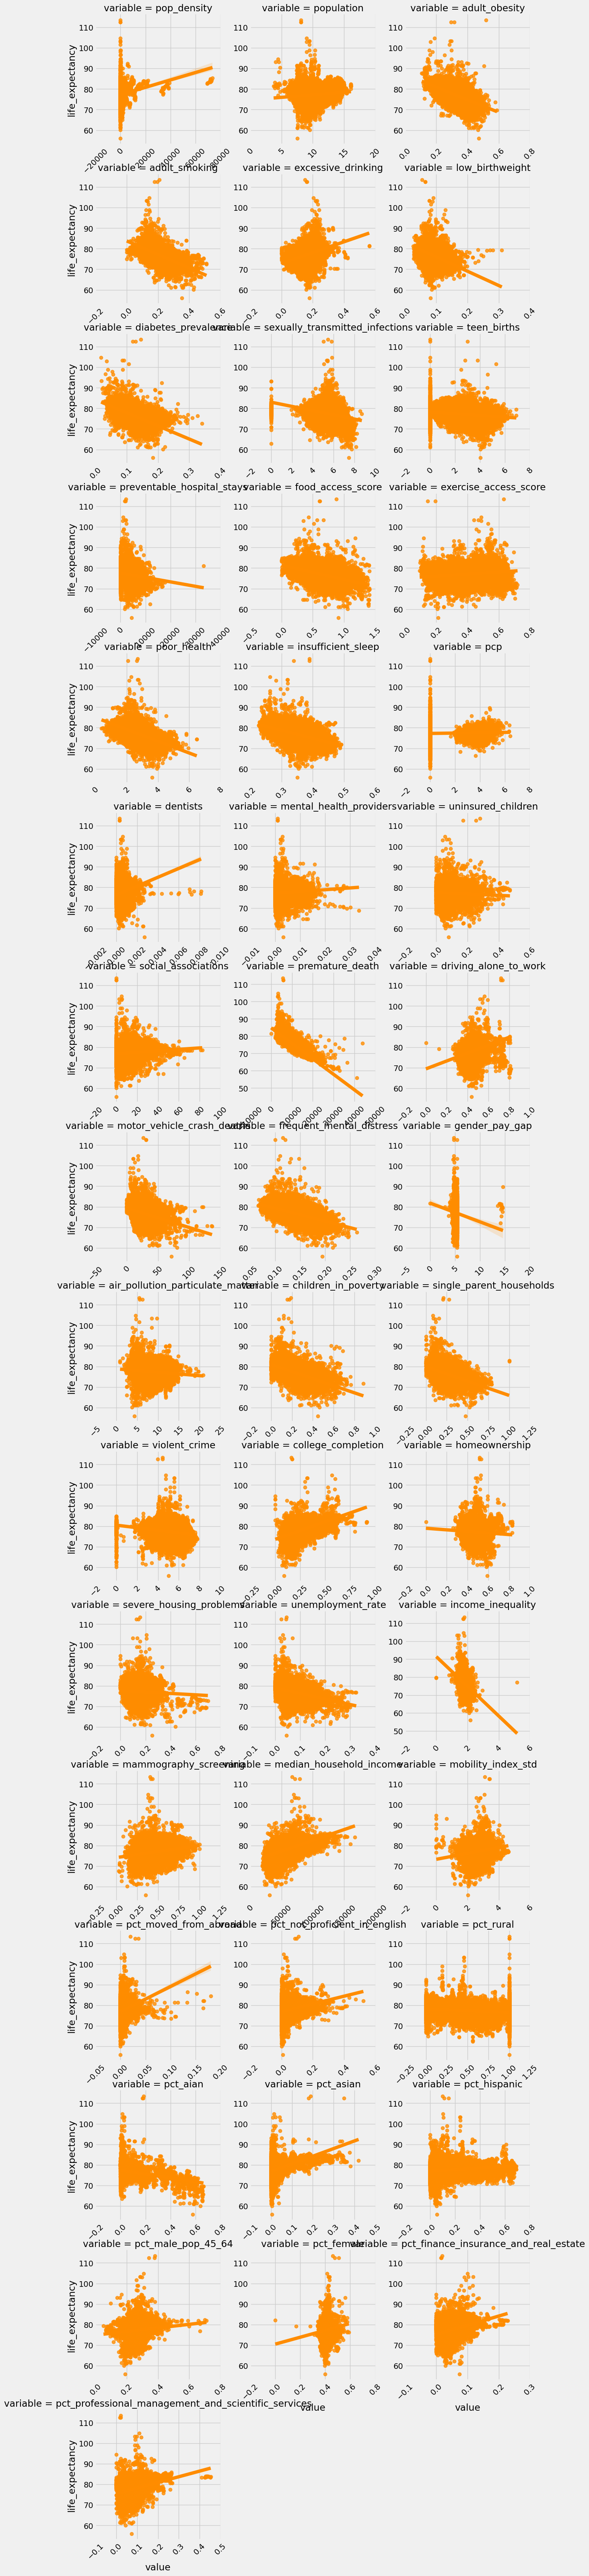

In [37]:
# Create scatterplots with regression line with regplot() of continuous variables

con_2 = pd.melt(df, id_vars='life_expectancy', value_vars=feat_cont.columns)
g = sns.FacetGrid(con_2, col='variable', col_wrap=3, sharex=False, sharey=False, height=4)
g = g.map(sns.regplot, 'value', 'life_expectancy', color='darkorange')
g.set_xticklabels(rotation=45)
# plt.savefig('images/df_scatter.png')

In [39]:
df.to_csv("data/chr_census_dataset_transformed.csv")

# Correlation Matrix

In [16]:
data.iloc[:, 6:].head()

,access_to_exercise_opportunities,adult_obesity,adult_smoking,air_pollution_particulate_matter,alcohol_impaired_driving_deaths,children_eligible_for_free_lunch,children_in_poverty,children_in_single_parent_households,college_completion,dentists,diabetes_prevalence,drinking_water_violations,driving_alone_to_work,excessive_drinking,food_environment_index,food_insecurity,frequent_mental_distress,gender_pay_gap,gini_index,high_school_completion,high_school_graduation,hiv_prevalence,homeownership,income_inequality,injury_deaths,insufficient_sleep,life_expectancy,limited_access_to_healthy_foods,long_commute_driving_alone,low_birthweight,mammography_screening,median_age,median_household_income,mental_health_providers,motor_vehicle_crash_deaths,other_pcp,pcp,pct_65_and_older,pct_aapi,pct_agriculture_hunting_and_mining,pct_arts_entertainment_and_accommodation_services,pct_asian,pct_construction,pct_educational_and_health_services,pct_female,pct_finance_insurance_and_real_estate,pct_hispanic,pct_households_with_high_housing_costs,pct_households_with_lack_of_kitchen_or_plumbing_facilities,pct_households_with_overcrowding,pct_indigenous,pct_information,pct_manufacturing,pct_mgmt_bus_sci_art_occupations,pct_nat_res_constr_maint_occupations,pct_nhpi,pct_non_hispanic_black,pct_non_hispanic_white,pct_not_proficient_in_english,pct_other_services,pct_prod_transp_mat_moving_occupations,pct_professional_management_and_scientific_services,pct_public_administration,pct_retail_trade,pct_rural,pct_sales_and_office_occupations,pct_service_occupations,pct_transportation_and_utilities,pct_under_18,pct_wholesale_trade,physical_inactivity,poor_mental_health_days,poor_or_fair_health,poor_physical_health_days,population,poverty,premature_age_adjusted_mortality,premature_death,preventable_hospital_stays,ratio_of_pop_to_dentists,ratio_of_pop_to_mental_health,ratio_of_pop_to_pcp,ratio_of_pop_to_pcp_other_than_physicians,severe_housing_cost_burden,severe_housing_problems,sexually_transmitted_infections,single_parent_households,social_associations,some_college,teen_births,unemployment_rate,uninsured_adults,violent_crime
0,0.6907,0.300,0.2814,12.5700,0.284338,0.161946,0.1380,0.2954,0.217477,0.000262,0.11818,0.000000,0.868566,0.154040,7.219912,0.13821,0.135139,66.048439,0.405,0.853323,0.715190,184.736484,0.775180,3.930128,72.504788,0.369589,75.607833,0.152482,31.206695,0.0883,0.658644,36.2,53255.0,0.000050,28.8,0.000248,52.224775,0.114006,0.006547,0.009449,0.086767,0.006547,0.077400,0.174315,0.515003,0.065322,0.023196,0.144260,0.009737,0.002029,0.002897,0.011257,0.141284,0.293291,0.115690,0.000000,0.178215,0.775524,0.009389,0.045520,0.131096,0.069964,0.116676,0.126659,0.441005,0.290703,0.169221,0.044246,0.277020,0.031141,0.32180,4.14,0.2586,5.48,53155.0,0.214724,441.808519,9778.1,91.803383,4120.317674,37113.103370,1914.800000,5074.504751,0.144260,0.096612,370.0,0.179785,13.455842,0.501062,47.513321,0.062076,0.140,256.487012
1,0.6523,0.245,0.2309,11.5998,0.321341,0.204360,0.1933,0.2852,0.268221,0.000464,0.10766,0.253189,0.835134,0.190255,7.651281,0.13214,0.136337,68.766137,0.439,0.875757,0.670437,177.725095,0.767301,4.214440,74.283360,0.335911,77.707111,0.037806,33.724273,0.0877,0.688273,41.0,50147.0,0.000326,23.6,0.000399,70.741370,0.164912,0.006570,0.018619,0.095237,0.006536,0.107106,0.179215,0.511340,0.068492,0.038955,0.174773,0.011083,0.004721,0.006064,0.017320,0.092078,0.315219,0.134832,0.000034,0.093793,0.840777,0.022074,0.049300,0.105578,0.098688,0.045950,0.137723,0.500277,0.268785,0.175586,0.053540,0.233084,0.036729,0.25185,4.06,0.1338,3.57,175791.0,0.130669,366.591291,8221.7,65.391299,2177.442032,4917.923172,1413.600000,2746.755160,0.174773,0.116501,245.9,0.138206,11.480511,0.576810,31.854171,0.065605,0.209,171.623233
2,0.3645,0.364,0.2268,12.0202,0.404637,0.362199,0.3410,0.5196,0.135124,0.000361,0.15103,0.187097,0.789877,0.110813,5.436531,0.22355,0.161515,74.681632,0.464,0.718629,0.563422,382.090476,0.680449,5.835112,66.512793,0.398820,75.719796,0.094833,

In [38]:
# Correlation Matrix between all variables
corr_matrix = data.iloc[:, 6:].corr()
plt.figure(figsize=(75, 45))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap="coolwarm",
    linecolor="black",
    linewidths=1.0,
    xticklabels=True,
    yticklabels=True,
)
plt.show()

NameError: name 'data' is not defined